# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [15]:
pip install palmerpenguins

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from plotnine import *
from palmerpenguins import load_penguins

In [17]:
# Code Here
df = load_penguins()
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [18]:
#dummify all variables that require this
df_clean = df.dropna()
df_dummies = pd.get_dummies(df_clean, columns=['island', 'sex'], drop_first=True, dtype=float)

Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [19]:
# Code Here
#fitting all the different models given

#prep features and target
X = df_dummies.drop('species', axis=1)
y = df_dummies['species']

#split data like notes show
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Split data with stratification "Keep in mind that you may need to stratify"
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#all models (4 total)
models = {
    'kNN (k=5)': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)),
    'kNN (k=10)': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=10)),
    'Decision Tree (shallow)': DecisionTreeClassifier(max_depth=3, random_state=42),
    'Decision Tree (deep)': DecisionTreeClassifier(max_depth=10, random_state=42)
}

#fit
fitted_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    fitted_models[name] = model

In [20]:
#Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.
#confusion matrix, overall accuracy, precision/recall/AUC/F1 for each species

for name, model in fitted_models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    #precision for class c = number of observations in class c that were predicted to be in c / number of observations predicted to be in class c"
    # recall for class c = number of observations in class c that were predicted to be in c / number of observations in class c"

    classes = model.classes_
    species_metrics = {}

    for i, species in enumerate(classes):
        # For each species, create binary species vs not species
        #all formulas are based on formulas said in words on ch.16 notes converted to code

        y_true_binary = (y_test == species).astype(int)
        y_pred_binary = (y_pred == species).astype(int)
        y_scores = y_pred_proba[:, i]

        # Calculate True Positives, False Positives, False Negatives
        TP = np.sum((y_true_binary == 1) & (y_pred_binary == 1))
        FP = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
        FN = np.sum((y_true_binary == 1) & (y_pred_binary == 0))

        # Precision = TP / (TP + FP)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall = TP / (TP + FN)
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 = 2 * precision * recall / (precision + recall)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        # AUC
        if len(np.unique(y_true_binary)) > 1:
            auc = roc_auc_score(y_true_binary, y_scores)
        else:
            auc = 1.0

        species_metrics[species] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }

In [21]:
cm

array([[41,  3,  0],
       [ 0, 20,  0],
       [ 2,  0, 34]])

In [22]:
accuracy

0.95

In [23]:
species_metrics

{'Adelie': {'precision': np.float64(0.9534883720930233),
  'recall': np.float64(0.9318181818181818),
  'f1': np.float64(0.942528735632184),
  'auc': np.float64(0.9480519480519479)},
 'Chinstrap': {'precision': np.float64(0.8695652173913043),
  'recall': np.float64(1.0),
  'f1': np.float64(0.9302325581395349),
  'auc': np.float64(0.9812500000000001)},
 'Gentoo': {'precision': np.float64(1.0),
  'recall': np.float64(0.9444444444444444),
  'f1': np.float64(0.9714285714285714),
  'auc': np.float64(0.9722222222222222)}}

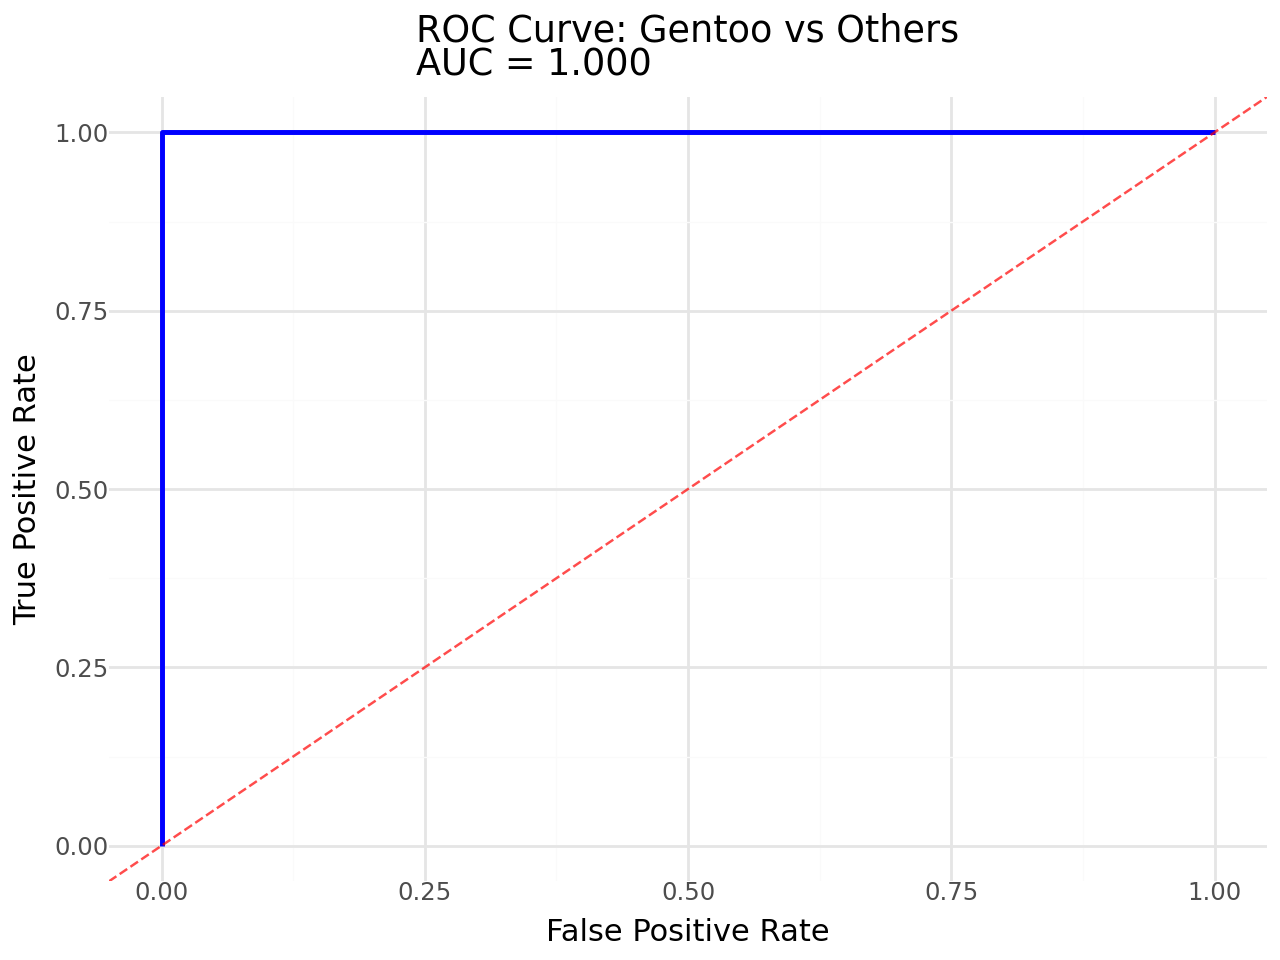

In [28]:
chosen_species = 'Gentoo'
chosen_model = fitted_models['kNN (k=5)']

# Binary classification: Gentoo vs Others
y_test_binary = (y_test == chosen_species).astype(int)
y_pred_proba = chosen_model.predict_proba(X_test)
classes = chosen_model.classes_
species_idx = list(classes).index(chosen_species)
y_scores = y_pred_proba[:, species_idx]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_scores)
auc_value = roc_auc_score(y_test_binary, y_scores)

# Create ROC plot
roc_data = pd.DataFrame({'False_Positive_Rate': fpr, 'True_Positive_Rate': tpr})

roc_plot = (ggplot(roc_data, aes(x='False_Positive_Rate', y='True_Positive_Rate')) +
            geom_line(color='blue', size=1) +
            geom_abline(intercept=0, slope=1, linetype='dashed', color='red', alpha=0.7) +
            labs(title=f'ROC Curve: {chosen_species} vs Others\nAUC = {auc_value:.3f}',
                 x='False Positive Rate', y='True Positive Rate') +
            theme_minimal())

roc_plot